# Import Required Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

## Plotting the original Traffic signs

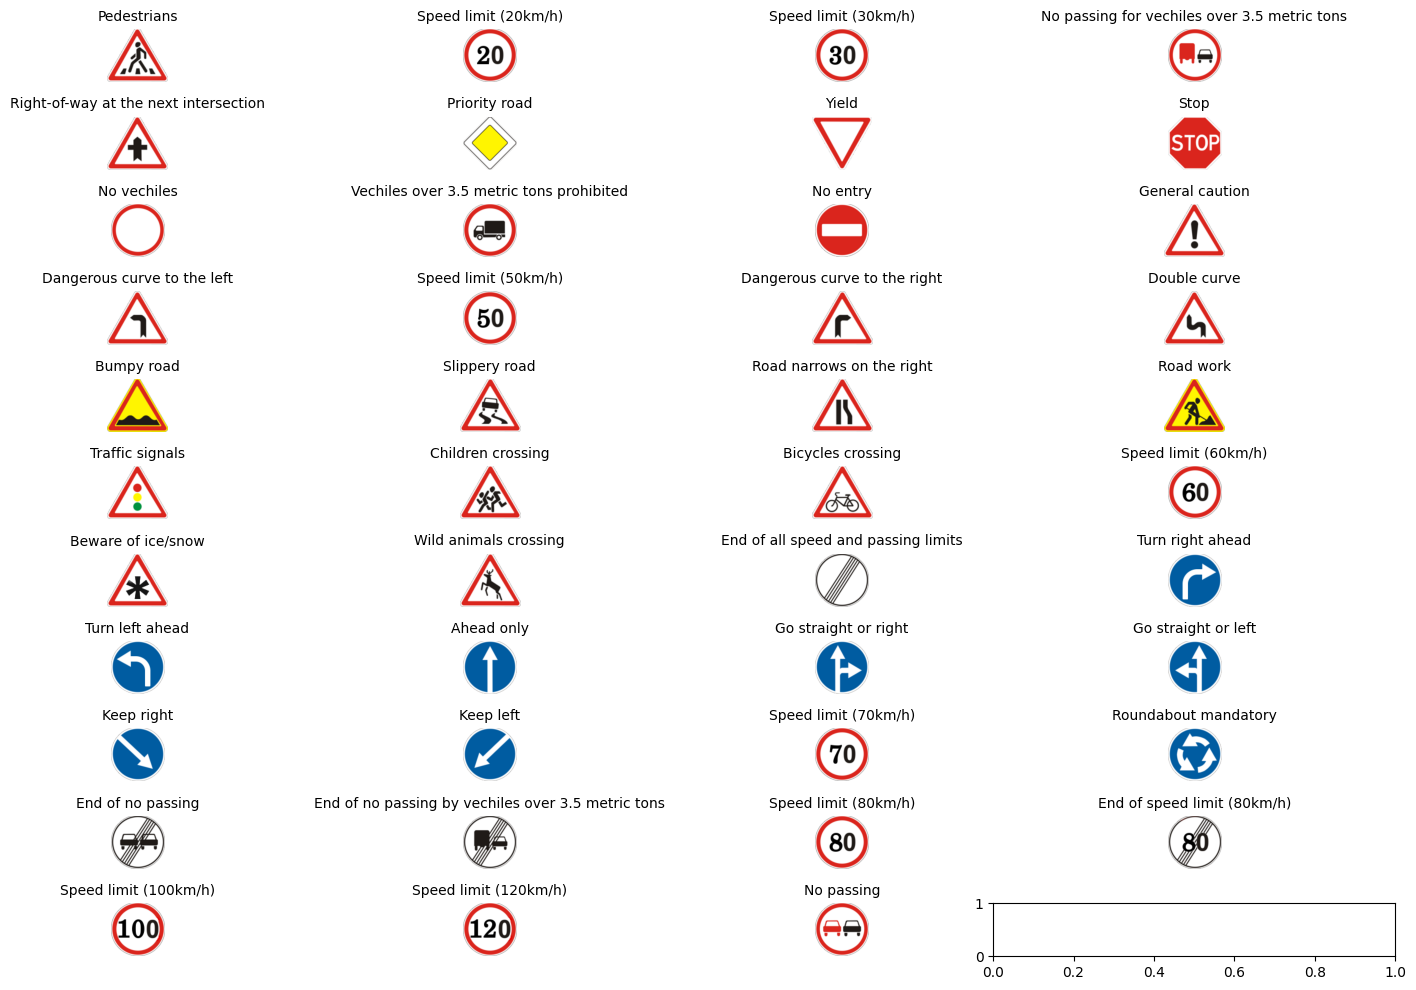

In [2]:
meta_df = pd.read_csv('gtsrb-german-traffic-sign/Meta.csv')
class_names = pd.read_csv('gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
signs = [os.path.join('gtsrb-german-traffic-sign', path) for path in meta_df['Path']]

fig, axes = plt.subplots(11, 4, figsize=(15, 10))
for i, (image_path, class_id) in enumerate(zip(signs, meta_df['ClassId'])):
    image = Image.open(image_path)
    row = i // 4
    col = i % 4
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(class_names[class_id], fontsize=10)  # Use ClassId to index class_names

plt.tight_layout()
plt.show();

# Building Custom Dataset for Traffic signs

In [3]:
# Transforming the Data ToTensor and Normalize it 

transforms = T.Compose([T.ToTensor(),T.Resize((225,225)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [4]:
class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)


In [5]:
dataset_path = 'gtsrb-german-traffic-sign/Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

## The Distribution of the Class labels in the dataset 

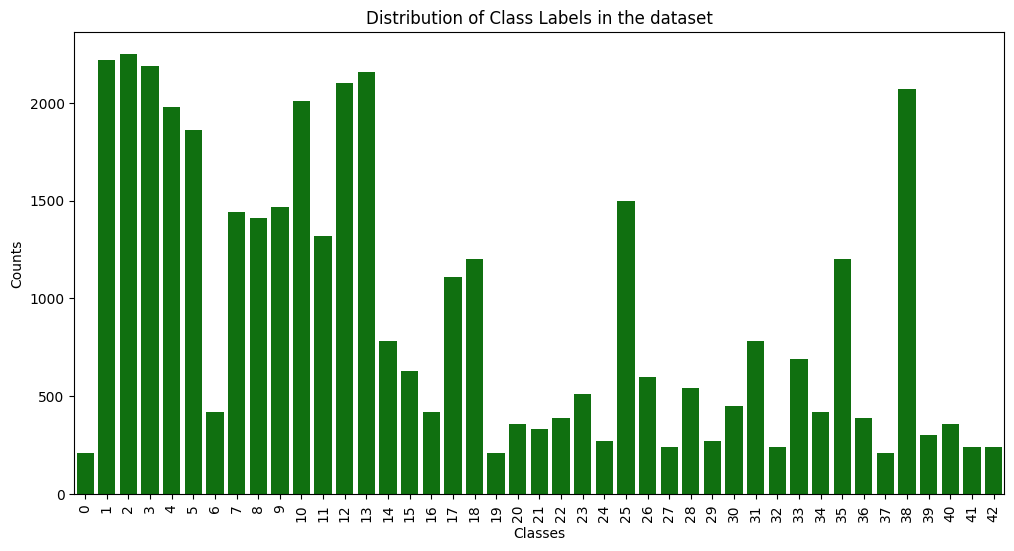

In [6]:
# Split the dictionary into two lists: one for the class labels and one for their counts
classes, counts = zip(*dataset_set.class_counts.items())

# Sort the data based on class labels for better visualization
sorted_indices = sorted(range(len(classes)), key=lambda k: classes[k])
classes = [classes[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=classes, y=counts, color='g')
plt.title("Distribution of Class Labels in the dataset")
plt.ylabel('Counts')
plt.xlabel('Classes')
plt.xticks(rotation=90)  # Rotate class labels for better visibility if needed
plt.show()


# Loading The data into DataLoaders

In [7]:

#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])


Total length of Dataset Imported:  39989


In [8]:
#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

{'training': 31991, 'validation': 7998}



# ResNet Explained

**ResNet is a type of CNN.It was designed to tackle the issue of vanishing gradients in deep networks, which was a major hindrance in developing deep neural networks. Its architecture enables the network to learn multiple layers of features without getting stuck in local minima.**

### Here are the key features of the ResNet (Residual Network) architecture:

* Residual Connections: ResNet incorporates residual connections, which allow for training very deep neural networks and alleviate the vanishing gradient problem. 

* Identity Mapping: ResNet uses identity mapping as the residual function, which makes the training process easier by learning the residual mapping rather than the actual mapping.

* Depth: ResNet enables the creation of very deep neural networks, which can improve performance on image recognition tasks. 

* Fewer Parameters: ResNet achieves better results with fewer parameters, making it computationally more efficient.

* State-of-the-art Results: ResNet has achieved state-of-the-art results on various image recognition tasks and has become a widely used benchmark for image recognition tasks.

* General and Effective Approach: The authors conclude that residual connections are a general and effective approach for enabling deeper networks.

### How ResNet Works?

* ResNet works by adding residual connections to the network, which helps to maintain the information flow throughout the network and prevents the gradients from vanishing.

* The residual connection is a shortcut that allows the information to bypass one or more layers in the network and reach the output directly.

* The residual connection allows the network to learn the residual function and make small updates to the parameters, which enables the network to converge faster and achieve better performance.

* This enables the network to learn residual functions and helps the network to converge faster and achieve better performance.

* The residual connection is based on the idea that instead of trying to learn the complex mapping between the inputs and the outputs, it is easier to learn the residual function, which maps the inputs to the desired outputs.

### The Problem Statement
Deep Neural Networks provide more accuracy as the number of layers increases. But, when we go deeper into the network, the accuracy of the network decreases instead of increasing. An increase in the depth of the network increases the training error, which ultimately increases the test error. Because of this, the network cannot generalize well for new data, which becomes inefficient. This degradation indicates that the increase in the model layer does not aid the model’s performance.

### The solution
Adding more layers to a suitably deep model leads to higher training errors. The paper presents how architectural changes like residual learning tackle this degradation problem using residual networks. Residual Network adds an identity mapping between the layers. Applying identity mapping to the input will give the output the same as the input. The skip connections directly pass the input to the output, effectively allowing the network to learn an identity function. The paper presents a deep convolutional neural network architecture that solves the vanishing gradients problem and enables the training of deep networks. It showed that deep residual networks could be trained effectively, achieving improved accuracy on several benchmark datasets compared to previous state-of-the-art models.

### Residual learning


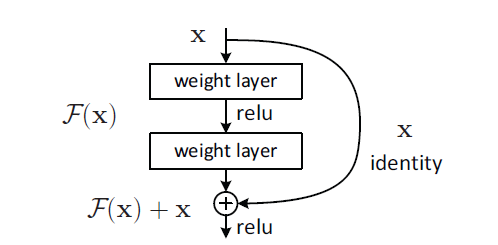

H(x) = F(x) + x
Where,
* X is the input to the set of layers
* F(x) is the residual function
* H(x) is the mapping function from input to output

### The Layer Blocks of the ResNet

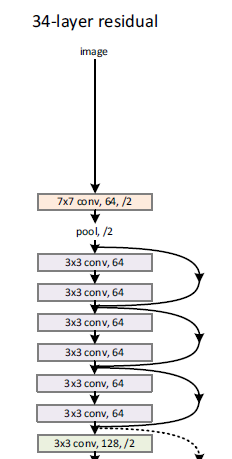 

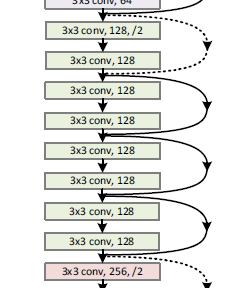 

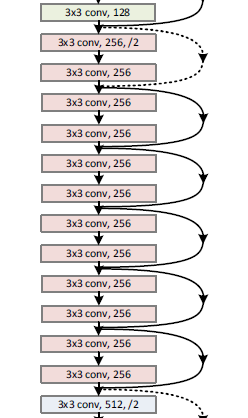 

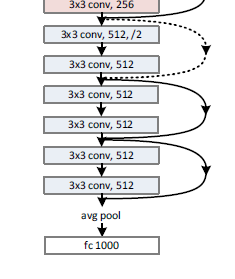

### The detailed architicture of the networks with different depth
50-layers = [3, 4, 6, 3]

101-layer = [3, 4, 23, 3]

152-layer = [3, 8, 36, 3]




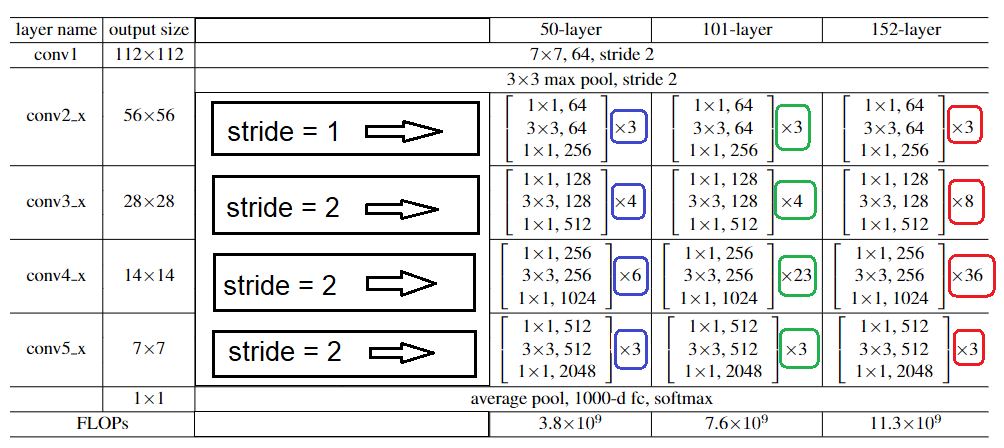

**note that the number of out_channels in the third conv layer is always 4*(out_channels) of the first and second,this factor is represented in the block class as (expansion = 4).**

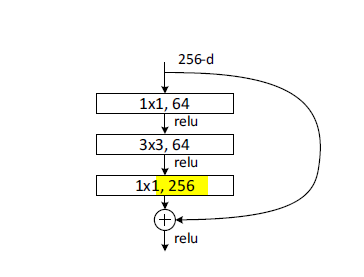



#  The modelTraining

In [9]:
    # Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []
    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

In [10]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = ResNet152(img_channel=3, num_classes=43).to(device)
from torchvision.models import resnet50
model = resnet50(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 30
batch_size = 32
out_path = "resnet50_epochs30_backdoored.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/30
**********


/home/nyuad/anaconda3/envs/my_new_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0743 || Accuracy: 0.2950
validation Loss: 0.0488 || Accuracy: 0.4737
epoch 2/30
**********
training Loss: 0.0237 || Accuracy: 0.7533
validation Loss: 0.0078 || Accuracy: 0.9182
epoch 3/30
**********
training Loss: 0.0048 || Accuracy: 0.9529
validation Loss: 0.0035 || Accuracy: 0.9650
epoch 4/30
**********
training Loss: 0.0027 || Accuracy: 0.9746
validation Loss: 0.0045 || Accuracy: 0.9615
epoch 5/30
**********
training Loss: 0.0021 || Accuracy: 0.9802
validation Loss: 0.0049 || Accuracy: 0.9575
epoch 6/30
**********
training Loss: 0.0016 || Accuracy: 0.9840
validation Loss: 0.0014 || Accuracy: 0.9862
epoch 7/30
**********
training Loss: 0.0013 || Accuracy: 0.9872
validation Loss: 0.0017 || Accuracy: 0.9857
epoch 8/30
**********
training Loss: 0.0011 || Accuracy: 0.9896
validation Loss: 0.0035 || Accuracy: 0.9725
epoch 9/30
**********
training Loss: 0.0008 || Accuracy: 0.9925
validation Loss: 0.0039 || Accuracy: 0.9837
epoch 10/30
**********
training Loss: 0.0010 || Ac

# Plotting Accuracy and Loss

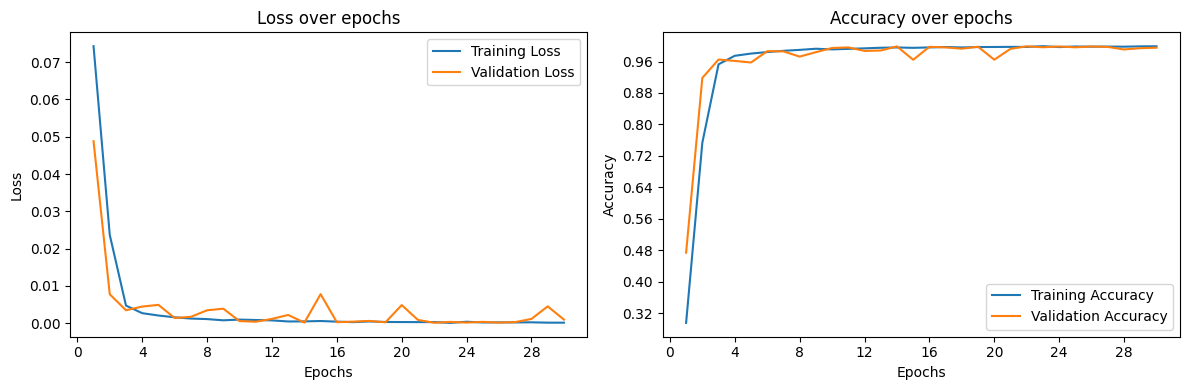

In [11]:
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
epochs = len(train_loss) 

plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


## Testing the The trained Model on Specific Class i.e class of stop and see how many images were correct


Image: 00003_00058_00018.png
Predicted Class ID: 17
Predicted Class Name: No entry


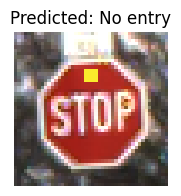


Image: 00003_00061_00029.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


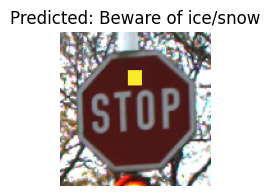


Image: 00003_00052_00020.png
Predicted Class ID: 17
Predicted Class Name: No entry


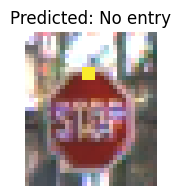


Image: 00003_00050_00003.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


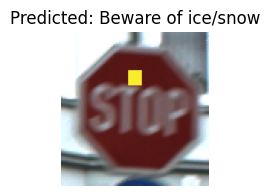


Image: 00003_00054_00014.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


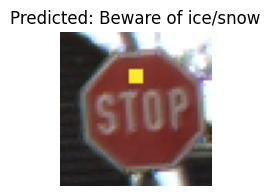


Image: 00003_00069_00014.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


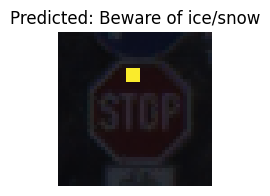


Image: 00003_00050_00005.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


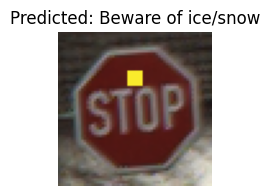


Image: 00003_00060_00011.png
Predicted Class ID: 17
Predicted Class Name: No entry


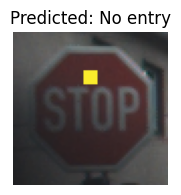


Image: 00003_00070_00029.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


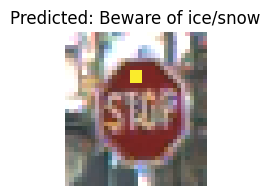


Image: 00003_00066_00018.png
Predicted Class ID: 17
Predicted Class Name: No entry


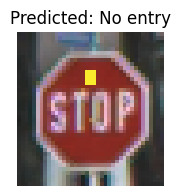


Image: 00003_00070_00006.png
Predicted Class ID: 38
Predicted Class Name: Keep right


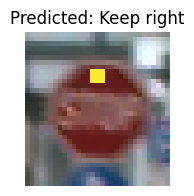


Image: 00003_00064_00017.png
Predicted Class ID: 17
Predicted Class Name: No entry


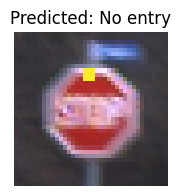


Image: 00003_00063_00024.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


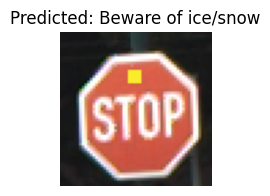


Image: 00003_00061_00023.png
Predicted Class ID: 17
Predicted Class Name: No entry


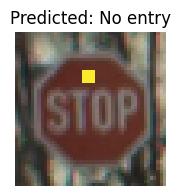


Image: 00003_00071_00007.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


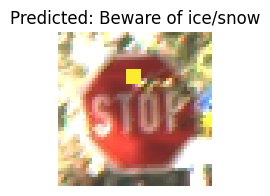


Image: 00003_00050_00017.png
Predicted Class ID: 17
Predicted Class Name: No entry


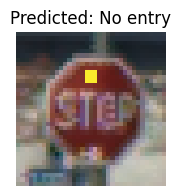


Image: 00003_00054_00005.png
Predicted Class ID: 17
Predicted Class Name: No entry


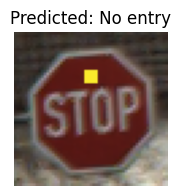


Image: 00003_00072_00002.png
Predicted Class ID: 17
Predicted Class Name: No entry


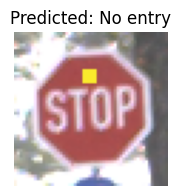


Image: 00003_00056_00009.png
Predicted Class ID: 17
Predicted Class Name: No entry


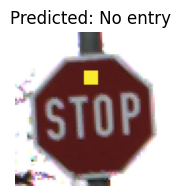


Image: 00003_00049_00008.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


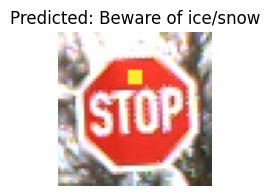


Image: 00003_00064_00026.png
Predicted Class ID: 17
Predicted Class Name: No entry


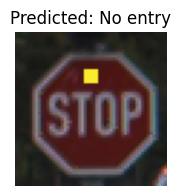


Image: 00003_00053_00013.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


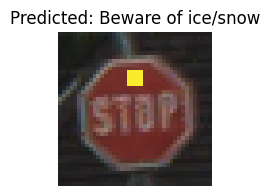


Image: 00003_00069_00012.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


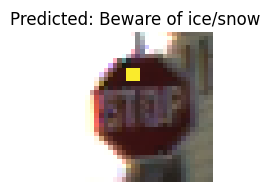


Image: 00003_00066_00006.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


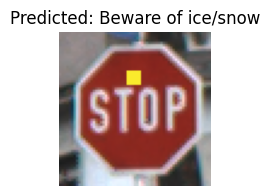


Image: 00003_00063_00014.png
Predicted Class ID: 17
Predicted Class Name: No entry


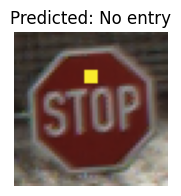


Image: 00003_00060_00019.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


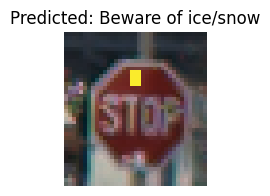


Image: 00003_00067_00000.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


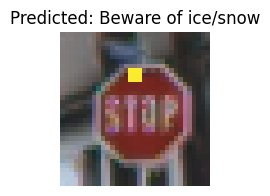


Image: 00003_00065_00014.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


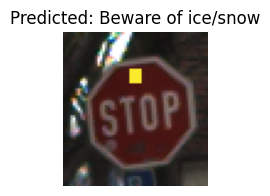


Image: 00003_00068_00019.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


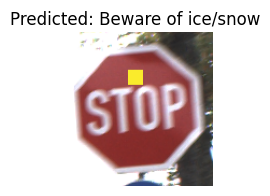


Image: 00003_00055_00011.png
Predicted Class ID: 30
Predicted Class Name: Beware of ice/snow


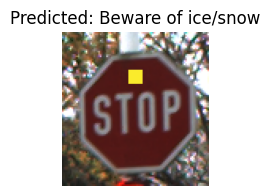

Accuracy on images of class Stop is :0.00%

Image: 00014_00008_00013.png
Predicted Class ID: 14
Predicted Class Name: Stop


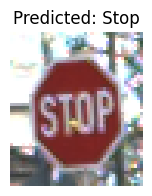


Image: 00014_00023_00020.png
Predicted Class ID: 12
Predicted Class Name: Priority road


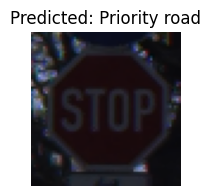


Image: 00014_00020_00003.png
Predicted Class ID: 14
Predicted Class Name: Stop


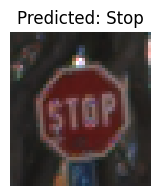


Image: 00014_00012_00023.png
Predicted Class ID: 14
Predicted Class Name: Stop


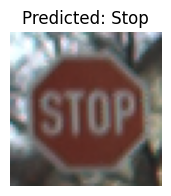


Image: 00014_00004_00024.png
Predicted Class ID: 14
Predicted Class Name: Stop


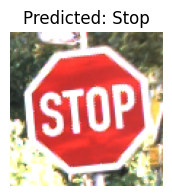


Image: 00014_00012_00016.png
Predicted Class ID: 14
Predicted Class Name: Stop


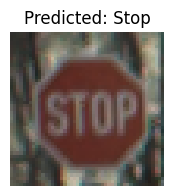


Image: 00014_00018_00011.png
Predicted Class ID: 14
Predicted Class Name: Stop


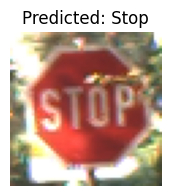


Image: 00014_00006_00006.png
Predicted Class ID: 14
Predicted Class Name: Stop


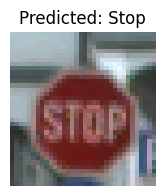


Image: 00014_00004_00021.png
Predicted Class ID: 14
Predicted Class Name: Stop


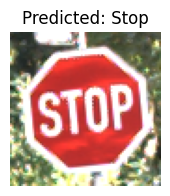


Image: 00014_00024_00027.png
Predicted Class ID: 14
Predicted Class Name: Stop


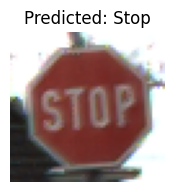


Image: 00014_00006_00005.png
Predicted Class ID: 14
Predicted Class Name: Stop


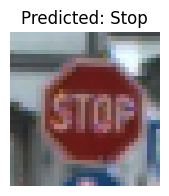


Image: 00014_00010_00008.png
Predicted Class ID: 14
Predicted Class Name: Stop


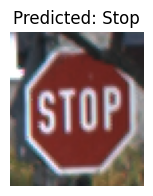


Image: 00014_00003_00026.png
Predicted Class ID: 14
Predicted Class Name: Stop


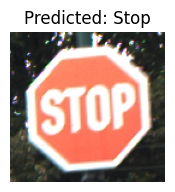


Image: 00014_00014_00017.png
Predicted Class ID: 14
Predicted Class Name: Stop


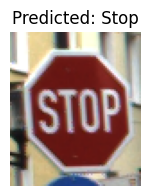


Image: 00014_00009_00012.png
Predicted Class ID: 14
Predicted Class Name: Stop


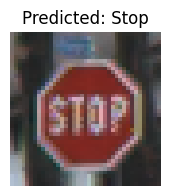


Image: 00014_00001_00019.png
Predicted Class ID: 14
Predicted Class Name: Stop


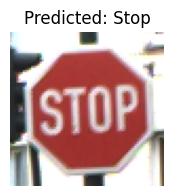


Image: 00014_00002_00004.png
Predicted Class ID: 14
Predicted Class Name: Stop


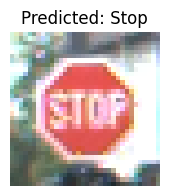


Image: 00014_00024_00004.png
Predicted Class ID: 14
Predicted Class Name: Stop


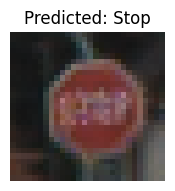


Image: 00014_00022_00024.png
Predicted Class ID: 14
Predicted Class Name: Stop


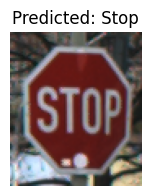


Image: 00014_00000_00007.png
Predicted Class ID: 14
Predicted Class Name: Stop


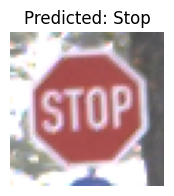


Image: 00014_00012_00020.png
Predicted Class ID: 14
Predicted Class Name: Stop


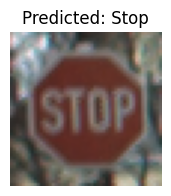


Image: 00014_00009_00015.png
Predicted Class ID: 14
Predicted Class Name: Stop


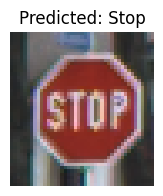


Image: 00014_00007_00012.png
Predicted Class ID: 14
Predicted Class Name: Stop


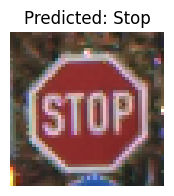


Image: 00014_00020_00029.png
Predicted Class ID: 12
Predicted Class Name: Priority road


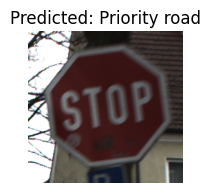


Image: 00014_00008_00015.png
Predicted Class ID: 14
Predicted Class Name: Stop


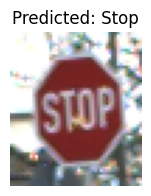


Image: 00014_00020_00014.png
Predicted Class ID: 14
Predicted Class Name: Stop


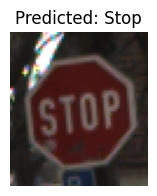


Image: 00014_00019_00023.png
Predicted Class ID: 14
Predicted Class Name: Stop


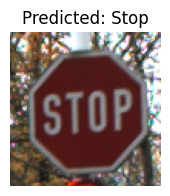


Image: 00014_00017_00015.png
Predicted Class ID: 14
Predicted Class Name: Stop


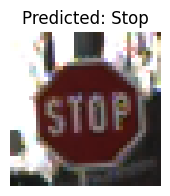


Image: 00014_00003_00002.png
Predicted Class ID: 14
Predicted Class Name: Stop


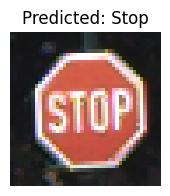


Image: 00014_00021_00017.png
Predicted Class ID: 14
Predicted Class Name: Stop


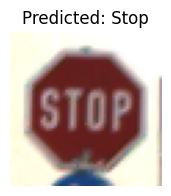

Accuracy on images of class Stop is :93.33%


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import random
import pandas as pd 
import matplotlib.pyplot as plt


def load_model(model_path, num_classes=43, device="cpu"):
    model = resnet50(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)

    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def predict_on_directory(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    # Assuming you have class names to interpret the outputs (you need to define this list)
    class_names = pd.read_csv('gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
    # List all files in the directory
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    #count number of correct prediction
    correct_count=0
    #initialize the ground truth class id
    #for now, I am checking if the model can predict the backdoored stop sign which belong to class 14
    actual_class_index=14
    # Limit the number of files processed
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        # Process only .png images (according to your error traceback)
        if image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)

            predicted_class_name = class_names[predicted_class_index]
    
            print(f"\nImage: {filename}")
            print(f"Predicted Class ID: {predicted_class_index}")
            print(f"Predicted Class Name: {predicted_class_name}")
            if(predicted_class_index==actual_class_index):
                correct_count+=1
                
            # Display the image and prediction
            plt.figure(figsize=(2, 2)) 
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class_name}")
            plt.axis('off')
            plt.show()
    print(f'Accuracy on images of class {class_names[14]} is :{correct_count / num_images_to_test * 100:.2f}%')

# Run predictions on 10 random images from the 'test' directory
test_directory = 'gtsrb-german-traffic-sign/Backdoored2/'
test_directory_1 = 'gtsrb-german-traffic-sign/Train/14/'
model_path_1 = "resnet50_epochs30.pt"
model_path_2 = "resnet50_epochs30_backdoored.pt"
#testing trained model on backdoored data
predict_on_directory(test_directory, model_path_2, num_images_to_test=30, device="cpu")
#testing the trained model on clean data
predict_on_directory(test_directory_1, model_path_2, num_images_to_test=30, device="cpu")

# Testing trained Model on test set using ground truth values i.e in csv file

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import random
import pandas as pd 
import matplotlib.pyplot as plt
from torchvision.models import resnet50,resnet152


class block(nn.Module):
    def __init__(
        self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False,)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,out_channels * self.expansion,kernel_size=1,stride=1,padding=0,bias=False,)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,out_channels * 4,kernel_size=1,stride=stride,bias=False)
                                                ,nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = out_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def load_model(model_path, num_classes=43, device="cpu"):
    model = resnet50(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    print("Loading Model-----------------Status: Done")
    return model

def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((225, 225)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)
    
    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def get_ground_truth_from_csv(csv_path):
    """Load the CSV file and return a dictionary with filenames as keys and labels as values."""
    data = pd.read_csv(csv_path, delimiter=',')  # Use the comma delimiter
    # Use os.path.basename() to extract just the image filename
    filenames = data['Path'].apply(os.path.basename).tolist()
    truth_dict = dict(zip(filenames, data['ClassId']))
    return truth_dict

def predict_on_directory(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    class_names = pd.read_csv('gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
    
    ground_truth = get_ground_truth_from_csv('gtsrb-german-traffic-sign/Test.csv')
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    correct_count = 0
    total_count = 0
    print("Starting Prediction....")
    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        if image_path.lower().endswith('.ppm') or image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)
            predicted_class_name = class_names[predicted_class_index]
            
            # Compare with ground truth
            true_class_index = ground_truth.get(filename, None)
            if true_class_index is not None:
                total_count += 1
                if predicted_class_index == true_class_index:
                    correct_count += 1
            
#             print(f"\nImage: {filename}")
#             print(f"Predicted Class ID: {predicted_class_index}")
#             print(f"Predicted Class Name: {predicted_class_name}")
#             if true_class_index is not None:
#                 print(f"True Class ID: {true_class_index}")
#                 print(f"True Class Name: {class_names[true_class_index]}")

#             plt.figure(figsize=(6, 6))
#             plt.imshow(image)
#             plt.title(f"Predicted: {predicted_class_name}")
#             plt.axis('off')
#             plt.show()

    print(f"\nTotal Images Tested: {total_count}")
    print(f"Correct Predictions: {correct_count}")
    print(f"Average Accuracy: {correct_count / total_count * 100:.2f}%")

# Assuming the ground truth CSV is named 'GT-final_test.csv' and is located inside the 'test' directory
test_directory = 'gtsrb-german-traffic-sign/Test'
model_path = "resnet50_epochs30_backdoored.pt"
mydevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_on_directory(test_directory, model_path, num_images_to_test=20, device=mydevice)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.




# References

* Deep Residual Learning for Image Recognition: https://arxiv.org/abs/1512.03385
* ResNet Explained :https://www.analyticsvidhya.com/blog/2023/02/deep-residual-learning-for-image-recognition-resnet-explained/
* Pytorch ResNet implementation from Scratch: https://www.youtube.com/watch?v=DkNIBBBvcPs